In [1]:
from statistics import mean

import itertools
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats import inter_rater as irr
from nltk import agreement

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
POSTS_PATH = 'datasets/hatespeech_hocon34k.csv'
POSTS = pd.read_csv(POSTS_PATH)

def get_posts_ph22():
    return POSTS.loc[(POSTS['phase']==2)].copy()

def get_posts_ph3_train():
    return POSTS.loc[(POSTS['phase']==3) & (POSTS['split_all']=='train')].copy()

def get_posts_ph3_valid():
    return POSTS.loc[(POSTS['phase']==3) & (POSTS['split_all']=='val')].copy()

def get_posts_ph3_test():
    return POSTS.loc[(POSTS['phase']==3) & (POSTS['split_all']=='test')].copy()

In [3]:
get_posts_ph22().dtypes

newspaper_id      int64
post_id           int64
annotator_id      int64
phase             int64
split_all        object
split_12         object
label            object
label_hs          int64
label_context     int64
text             object
dtype: object

In [4]:
FLEISS_KAPPA_INTERVALS = {
    'poor': lambda x: x < 0,
    'slight': lambda x: (x > 0) & (x <= 0.2),
    'fair': lambda x: (x > 0.2) & (x <= 0.4),
    'moderate': lambda x: (x > 0.4) & (x <= 0.6),
    'substantial': lambda x: (x > 0.6) & (x <= 0.8),
    'almost perfect': lambda x: x > 0.8
}

def get_fleiss_kappa(dataframe, annotator_col, post_col, label_col):
    data_arr = pd.pivot(dataframe, columns=annotator_col, index=post_col, values=label_col).to_numpy()
    return irr.fleiss_kappa(irr.aggregate_raters(data_arr)[0], method='fleiss')

def get_fleiss_kappa_interpretation(kappa_value):
    for key, value in FLEISS_KAPPA_INTERVALS.items():
        if FLEISS_KAPPA_INTERVALS[key](kappa_value):
            return key

In [5]:
def get_hatespeech(label):
    return 'Hatespeech' if label == 'Hatespeech (enough context)' or label == 'Hatespeech (not enough context)' else 'Not Hatespeech'

In [6]:
def get_context(label):
    return 'Not Enough Context' if label == 'Not Hatespeech (not enough context)' or label == 'Hatespeech (not enough context)' else 'Enough Context'

In [7]:
def print_annotations_info(annotations):
    annotations = annotations
    annotators = annotations['annotator_id'].unique()
    display(annotators)
    print('Number of annotators:', len(annotators))
    print('Number of annotations:', len(annotations))

In [8]:
def get_quorums(annotations, num_annotators, num_combinations=None):
    if num_annotators % 2 == 0:
        raise ValueError('Parameter num_annotators must be odd and greater than 0.')
        
    if num_combinations is not None:
        if num_combinations < 2:
            raise ValueError('Parameter num_combinations must be greater than 1.')
        else:
            max_combinations = len(list(itertools.combinations(annotations['annotator_id'].unique(), num_annotators)))
            if num_combinations > max_combinations:
                num_combinations = max_combinations
    
    quorums = []
    
    for post_id in annotations['post_id'].unique().tolist():
        post_annotations = annotations.loc[annotations['post_id'] == post_id]['label'].tolist()
        if num_combinations is not None:
            random.seed(post_id + 42)
            combinations = random.sample(list(itertools.combinations(post_annotations, num_annotators)), num_combinations)
        else:
            combinations = list(itertools.combinations(post_annotations, num_annotators))
        group_id = 0
        for combination in combinations:
            group_id += 1
            quorums.append((group_id, post_id, max(set(combination), key=combination.count)))
    
    quorum_df = pd.DataFrame(quorums, columns=['group_id', 'post_id', 'label'])
    return quorum_df

In [9]:
def get_expert_agreement(dataframe, annotator_name_col, post_col, label_col, expert_name):
    annotators = dataframe[annotator_name_col].unique()
    
    agreement_dict = []
    for annotator in annotators:
        kappa_annotators = set([expert_name] + [annotator])
        annotations = dataframe.loc[dataframe[annotator_name_col].isin(kappa_annotators)]
        
        if len(kappa_annotators) > 1:
            kappa_value = round(get_fleiss_kappa(annotations, 'annotator_id', 'post_id', 'label'), 6)
        
            agreement_dict.append(
                {
                    'Annotator': annotator,
                    'Expert Agreement (' + str(expert_name) + ')': kappa_value,
                    'Interpretation': get_fleiss_kappa_interpretation(kappa_value)
                }
            )
        else:
            kappa_value = 1
            agreement_dict.append(
                {
                    'Annotator': expert_name,
                    'Expert Agreement (' + str(expert_name) + ')': kappa_value,
                    'Interpretation': get_fleiss_kappa_interpretation(kappa_value)
                }
            )
    
    expert_agreement = pd.DataFrame(agreement_dict)
    expert_agreement = expert_agreement.sort_values(expert_agreement.columns[1], ascending=False).reset_index(drop=True)
    
    return expert_agreement

In [10]:
annotations = get_posts_ph22()

print_annotations_info(annotations)

print()

fleiss_kappa = get_fleiss_kappa(annotations, 'annotator_id', 'post_id', 'label')
print('Fleiss\' Kappa:', fleiss_kappa)

annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(get_hatespeech)
fleiss_kappa = get_fleiss_kappa(annotations, 'annotator_id', 'post_id', 'label')
print('Fleiss\' Kappa (\'Hatespeech\' / \'Not Hatespeech\'):', fleiss_kappa)

annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(get_context)
fleiss_kappa = get_fleiss_kappa(annotations, 'annotator_id', 'post_id', 'label')
print('Fleiss\' Kappa (\'Enough Context\' / \'Not Enough Context\'):', fleiss_kappa)

annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(
    lambda label: 'Not Enough Context' 
    if label == 'Not Hatespeech (not enough context)' or label == 'Hatespeech (not enough context)' 
    else label)
fleiss_kappa = get_fleiss_kappa(annotations, 'annotator_id', 'post_id', 'label')
print('Fleiss\' Kappa (\'Hatespeech (enough context)\' / \'Not Hatespeech (enough context)\' / \'Not Enough Context\'):', 
      fleiss_kappa)

array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

Number of annotators: 29
Number of annotations: 1508

Fleiss' Kappa: 0.26010425203306836
Fleiss' Kappa ('Hatespeech' / 'Not Hatespeech'): 0.44275282259393484
Fleiss' Kappa ('Enough Context' / 'Not Enough Context'): 0.0917068714278168
Fleiss' Kappa ('Hatespeech (enough context)' / 'Not Hatespeech (enough context)' / 'Not Enough Context'): 0.2771896295099207


,Annotator,Expert Agreement (48),Interpretation
0,48,1.000000,almost perfect
1,54,0.866837,almost perfect
2,39,0.745098,substantial
3,41,0.706333,substantial
4,62,0.684848,substantial
5,61,0.678303,substantial
6,52,0.665287,substantial
7,58,0.612422,substantial
8,53,0.609023,substantial
9,47,0.609023,substantial


<Axes: xlabel='Interpretation'>

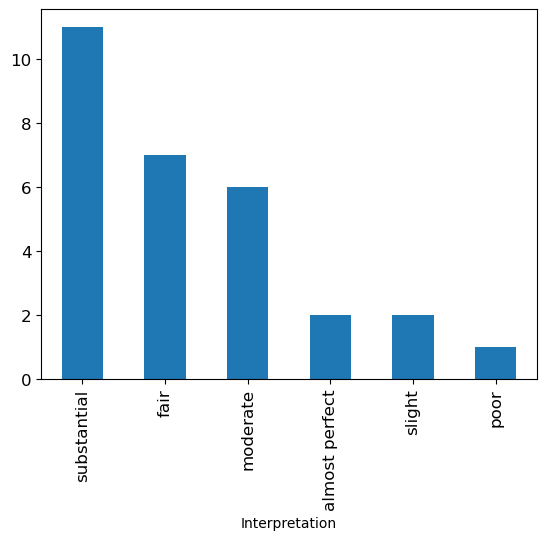

In [11]:
annotations = get_posts_ph22()

annotations['label'] = annotations['label'].apply(get_hatespeech)

posts_ph3_train = get_posts_ph3_train()
posts_ph3_train['label'] = posts_ph3_train['label'].apply(get_hatespeech)

posts_ph3_valid = get_posts_ph3_valid()
posts_ph3_valid['label'] = posts_ph3_valid['label'].apply(get_hatespeech)

posts_ph3_test = get_posts_ph3_test()
posts_ph3_test['label'] = posts_ph3_test['label'].apply(get_hatespeech)

expert_id = 48

expert_agreement = get_expert_agreement(annotations, 'annotator_id', 'post_id', 'label', expert_id)

expert_agreement.to_csv('figures/expert_agreement.csv', encoding='utf-8', index=False)

display(expert_agreement)

expert_agreement[expert_agreement.columns[2]].value_counts().plot(kind='bar', fontsize=12)

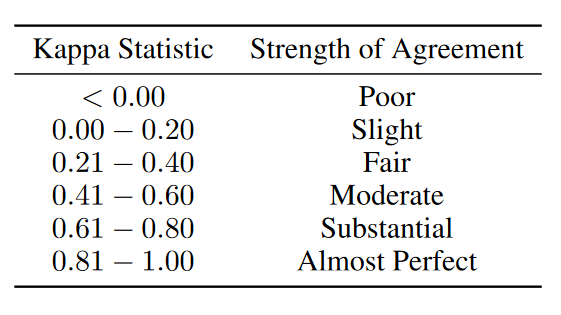

In [12]:
from IPython.display import Image
Image(filename='figures/kappa.png', width = 350)

In [13]:
annotator_groups = {}

for key, value in FLEISS_KAPPA_INTERVALS.items():
    annotator_groups[key] = expert_agreement.loc[expert_agreement['Interpretation'] == key]['Annotator'].to_list()

print('Fleiss\' kappa for members of expert agreement intervals:\n')

for key, value in annotator_groups.items():
    annotator_names = annotator_groups[key]
    if len(annotator_names) > 1:
        group_annotations = annotations.loc[annotations['annotator_id'].isin(annotator_names)]
        fleiss_kappa = get_fleiss_kappa(group_annotations, 'annotator_id', 'post_id', 'label')
        print(key.capitalize() + ':', fleiss_kappa)
    else:
        print(key.capitalize() + ': -')

print()

annotator_names = annotator_groups['moderate'] + annotator_groups['substantial']
if len(annotator_names) > 1:
    group_annotations = annotations.loc[annotations['annotator_id'].isin(annotator_names)]
    fleiss_kappa = get_fleiss_kappa(group_annotations, 'annotator_id', 'post_id', 'label')
    print('Moderate + substantial:', fleiss_kappa)
else:
    print('Moderate + substantial: -')

annotator_names = annotator_groups['moderate'] + annotator_groups['substantial'] + annotator_groups['almost perfect']
if len(annotator_names) > 1:
    group_annotations = annotations.loc[annotations['annotator_id'].isin(annotator_names)]
    fleiss_kappa = get_fleiss_kappa(group_annotations, 'annotator_id', 'post_id', 'label')
    print('Moderate + substantial + almost perfect:', fleiss_kappa)
else:
    print('Moderate + substantial + almost perfect: -')

annotator_names = annotator_groups['substantial'] + annotator_groups['almost perfect']
if len(annotator_names) > 1:
    group_annotations = annotations.loc[annotations['annotator_id'].isin(annotator_names)]
    fleiss_kappa = get_fleiss_kappa(group_annotations, 'annotator_id', 'post_id', 'label')
    print('Substantial + almost perfect:', fleiss_kappa)
else:
    print('Substantial + almost perfect: -')

Fleiss' kappa for members of expert agreement intervals:

Poor: -
Slight: 0.05797101449275391
Fair: 0.48726617083615065
Moderate: 0.4305958132045087
Substantial: 0.5547205150717004
Almost perfect: 0.8668373879641486

Moderate + substantial: 0.5147189517044535
Moderate + substantial + almost perfect: 0.5355278051630333
Substantial + almost perfect: 0.5834504976445635


In [14]:
annotator_list = list(expert_agreement[[expert_agreement.columns[0], expert_agreement.columns[1]]].itertuples(index=False, name=None))

agreement_dict = []
annotator_names = []

for idx, annotator in enumerate(annotator_list):
    annotator_names.append(annotator[0])
    
    group_annotations = annotations.loc[annotations['annotator_id'].isin(annotator_names)]

    group_posts_ph3_train = posts_ph3_train.loc[posts_ph3_train['annotator_id'].isin(annotator_names)]
    group_posts_ph3_valid = posts_ph3_valid.loc[posts_ph3_valid['annotator_id'].isin(annotator_names)]
    group_posts_ph3_test = posts_ph3_test.loc[posts_ph3_test['annotator_id'].isin(annotator_names)]
    
    if idx < len(annotator_list) - 1:
        expert_agreement_bound = '{0:0.4f} < x ≤ {1:0.4f}'.format(annotator_list[idx + 1][1], annotator[1])
    else:
        expert_agreement_bound = 'x ≥ {0:0.4f}'.format(annotator[1])
    
    if len(annotator_names) > 1:
        fleiss_kappa = get_fleiss_kappa(group_annotations, 'annotator_id', 'post_id', 'label')
    else:
        fleiss_kappa = 1
        
    agreement_dict.append(
        {
            'Expert Agreement (' + str(expert_id) + ')': expert_agreement_bound,
            'Fleiss\' Kappa': '{0:0.4f}'.format(fleiss_kappa),
            'Number of annotators': len(annotator_names),
            'Annotators': annotator_names.copy(),
            'Posts total': len(group_posts_ph3_train) + len(group_posts_ph3_valid) + len(group_posts_ph3_test),
            'Train-Posts': len(group_posts_ph3_train),
            'HS-Quote (Train)': '{0:0.2f}'.format(len(group_posts_ph3_train.loc[group_posts_ph3_train['label'] == 'Hatespeech']) * 100 / len(group_posts_ph3_train)) + ' %',
            'Valid-Posts': len(group_posts_ph3_valid),
            'HS-Quote (Valid)': '{0:0.2f}'.format(len(group_posts_ph3_valid.loc[group_posts_ph3_valid['label'] == 'Hatespeech']) * 100 / len(group_posts_ph3_valid)) + ' %',
            'Test-Posts': len(group_posts_ph3_test),
            'HS-Quote (Test)': '{0:0.2f}'.format(len(group_posts_ph3_test.loc[group_posts_ph3_test['label'] == 'Hatespeech']) * 100 / len(group_posts_ph3_test)) + ' %'
        }
    )
        

expert_agreement_intervals = pd.DataFrame(agreement_dict)

display(expert_agreement_intervals)

expert_agreement_intervals.to_csv('figures/expert_agreement_intervals.csv', encoding='utf-8', index=False)

,Expert Agreement (48),Fleiss' Kappa,Number of annotators,Annotators,Posts total,Train-Posts,HS-Quote (Train),Valid-Posts,HS-Quote (Valid),Test-Posts,HS-Quote (Test)
0,0.8668 < x ≤ 1.0000,1.0000,1,[48],627,494,45.34 %,64,45.31 %,69,57.97 %
1,0.7451 < x ≤ 0.8668,0.8668,2,"[48, 54]",729,579,43.87 %,73,43.84 %,77,54.55 %
2,0.7063 < x ≤ 0.7451,0.7669,3,"[48, 54, 39]",1729,1370,28.54 %,170,28.82 %,189,33.33 %
3,0.6848 < x ≤ 0.7063,0.6986,4,"[48, 54, 39, 41]",3779,3010,27.51 %,381,28.61 %,388,32.73 %
4,0.6783 < x ≤ 0.6848,0.6449,5,"[48, 54, 39, 41, 62]",5779,4603,31.46 %,573,31.59 %,603,35.16 %
5,0.6653 < x ≤ 0.6783,0.6249,6,"[48, 54, 39, 41, 62, 61]",6358,5056,30.58 %,641,31.20 %,661,34.19 %
6,0.6124 < x ≤ 0.6653,0.6229,7,"[48, 54, 39, 41, 62, 61, 52]",8858,7073,24.54 %,859,26.54 %,926,26.78 %
7,0.6090 < x ≤ 0.6124,0.6097,8,"[48, 54, 39, 41, 62, 61, 52, 58]",8858,7073,24.54 %,859,26.54 %,926,26.78 %
8,0.6090 < x ≤ 0.6090,0.6058,9,"[48, 54, 39, 41, 62, 61, 52, 58, 53]",11858,9469,20.38 %,1156,21.28 %,1233,22.06 %
9,0.6090 < x ≤ 0.6090,0.6056,10,"[48, 54, 39, 41, 62, 61, 52, 58, 53, 47]",11858,9469,20.38 %,1156,21.28 %,1233,22.06 %


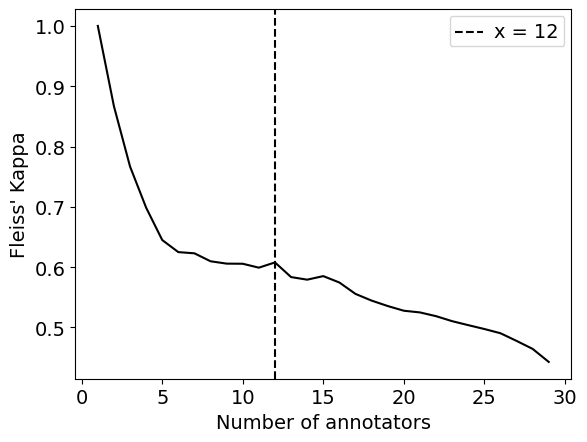

In [15]:
expert_agreement_intervals[['Number of annotators', 'Fleiss\' Kappa']] = expert_agreement_intervals[['Number of annotators', 'Fleiss\' Kappa']].apply(pd.to_numeric)
expert_agreement_intervals.plot(x='Number of annotators', y='Fleiss\' Kappa', label='', fontsize=14, color='black')
plt.axvline(x=12, ls='--', color='black', label='x = 12')
legend = plt.legend()
plt.setp(legend.get_texts(), fontsize=14)
plt.xlabel('Number of annotators', fontsize=14)
plt.ylabel('Fleiss\' Kappa', fontsize=14)
plt.savefig('figures/optimization_fleiss_kappa.pgf', bbox_inches='tight', pad_inches=0.0)
plt.show()

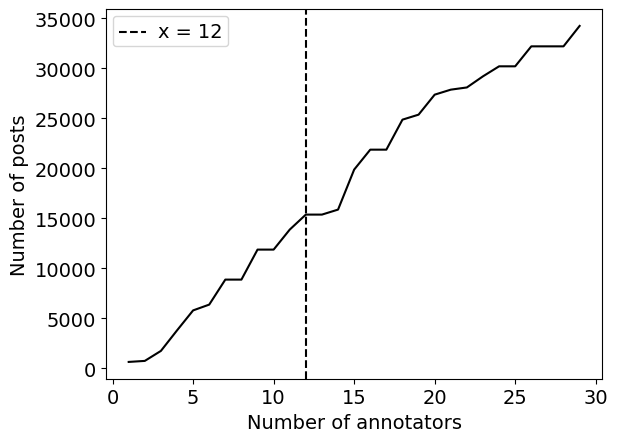

In [16]:
expert_agreement_intervals[['Number of annotators', 'Posts total']] = expert_agreement_intervals[['Number of annotators', 'Posts total']].apply(pd.to_numeric)
expert_agreement_intervals.plot(x='Number of annotators', y='Posts total', xlabel='Number of annotators', ylabel='Number of posts', label='', fontsize=14, color='black')
plt.axvline(x=12, ls='--', color='black', label='x = 12')
legend = plt.legend()
plt.setp(legend.get_texts(), fontsize=14)
plt.xlabel('Number of annotators', fontsize=14)
plt.ylabel('Number of posts', fontsize=14)
plt.savefig('figures/optimization_num_posts.pgf', bbox_inches='tight', pad_inches=0.0)
plt.show()

In [17]:
expert_agreement_intervals.loc[expert_agreement_intervals["Number of annotators"]==12,["Number of annotators", "Posts total", "Train-Posts", "Test-Posts", "Valid-Posts"]]

,Number of annotators,Posts total,Train-Posts,Test-Posts,Valid-Posts
11,12,15358,12275,1592,1491


In [18]:
annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(
        lambda label: 'Hatespeech' 
        if label == 'Hatespeech (enough context)' or label == 'Hatespeech (not enough context)' 
        else 'Not Hatespeech')


annotator_names = [48, 54]

annotations = annotations.loc[annotations['annotator_id'].isin(annotator_names)]

annotations_pivot = annotations.pivot_table(values='label', index='text', columns='annotator_id', aggfunc='first')

annotations_pivot.to_csv('figures/community_manager_posts_2-2.csv', encoding='utf-8')

In [19]:
annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(get_hatespeech)
quorums = get_quorums(annotations, 1)
fleiss_kappa = get_fleiss_kappa(quorums, 'group_id', 'post_id', 'label')
print('Fleiss\' Kappa 1er-Quorum (\'Hatespeech\' / \'Not Hatespeech\'):', fleiss_kappa)

Fleiss' Kappa 1er-Quorum ('Hatespeech' / 'Not Hatespeech'): 0.44275282259393484


In [20]:
annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(get_hatespeech)
quorums = get_quorums(annotations, 3)
fleiss_kappa = get_fleiss_kappa(quorums, 'group_id', 'post_id', 'label')
print('Fleiss\' Kappa 3er-Quorum (\'Hatespeech\' / \'Not Hatespeech\'):', fleiss_kappa)

Fleiss' Kappa 3er-Quorum ('Hatespeech' / 'Not Hatespeech'): 0.6512793473981385


In [21]:
annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(get_hatespeech)
quorums = get_quorums(annotations, 5)
fleiss_kappa = get_fleiss_kappa(quorums, 'group_id', 'post_id', 'label')
print('Fleiss\' Kappa 5er-Quorum (\'Hatespeech\' / \'Not Hatespeech\'):', fleiss_kappa)

Fleiss' Kappa 5er-Quorum ('Hatespeech' / 'Not Hatespeech'): 0.7492505171079924


In [22]:
annotations = get_posts_ph22()
annotations['label'] = annotations['label'].apply(get_hatespeech)

annotators = annotations['annotator_id'].unique()

annotations = pd.pivot_table(annotations, columns='label', index='post_id', aggfunc='size', fill_value=0)
display(annotations)

label,Hatespeech,Not Hatespeech
post_id,,
463609874,26,3
611220840,3,26
621521419,22,7
672311897,15,14
713701131,5,24
739250555,25,4
858645140,6,23
910613093,0,29
1071442535,1,28
